In [146]:
import os

import psycopg
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow

TABLE_NAME = "users_churn" # таблица с данными в postgres 

TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5000

EXPERIMENT_NAME = "real_churn_Andrey"
RUN_NAME = "eda"
REGISTRY_MODEL_NAME = "real_churn_model_Andrey"


ASSETS_DIR = "assets"

#os.mkdir(ASSETS_DIR)

pd.options.display.max_columns = 100
pd.options.display.max_rows = 64

sns.set_style("white")
sns.set_theme(style="whitegrid") 


In [147]:
pd.options.display.max_columns = 100
pd.options.display.max_rows = 64 

In [148]:
connection = {"sslmode": "require", "target_session_attrs": "read-write"}
postgres_credentials = {
    "host": os.environ["DB_DESTINATION_HOST"], 
    "port": os.environ["DB_DESTINATION_PORT"],
    "dbname": os.environ["DB_DESTINATION_NAME"],
    "user": os.environ["DB_DESTINATION_USER"],
    "password": os.environ["DB_DESTINATION_PASSWORD"],
}
connection.update(postgres_credentials)

with psycopg.connect(**connection) as conn:

    with conn.cursor() as cur:
        cur.execute(f"SELECT * FROM {TABLE_NAME}")
        data = cur.fetchall()
        columns = [col[0] for col in cur.description]

df = pd.DataFrame(data, columns=columns)

df.head(2) 

,id,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines,target
0,4815,7270-BDIOA,2017-12-01,2019-10-01,Month-to-month,Yes,Electronic check,90.00,1993.80,Fiber optic,No,No,No,Yes,Yes,No,Female,0,No,No,Yes,1
1,3860,1732-FEKLD,2015-08-01,NaT,One year,Yes,Bank transfer (automatic),94.75,5121.75,Fiber optic,No,Yes,Yes,No,Yes,No,Female,0,No,No,Yes,0


/tmp/ipykernel_416159/2887296336.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1, 0].set_xticklabels(df[x].unique(), rotation = 45);
/tmp/ipykernel_416159/2887296336.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0, 1].set_xticklabels(df[x].unique(), rotation = 45);
/tmp/ipykernel_416159/2887296336.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1, 1].set_xticklabels(df[x].unique(), rotation = 45);


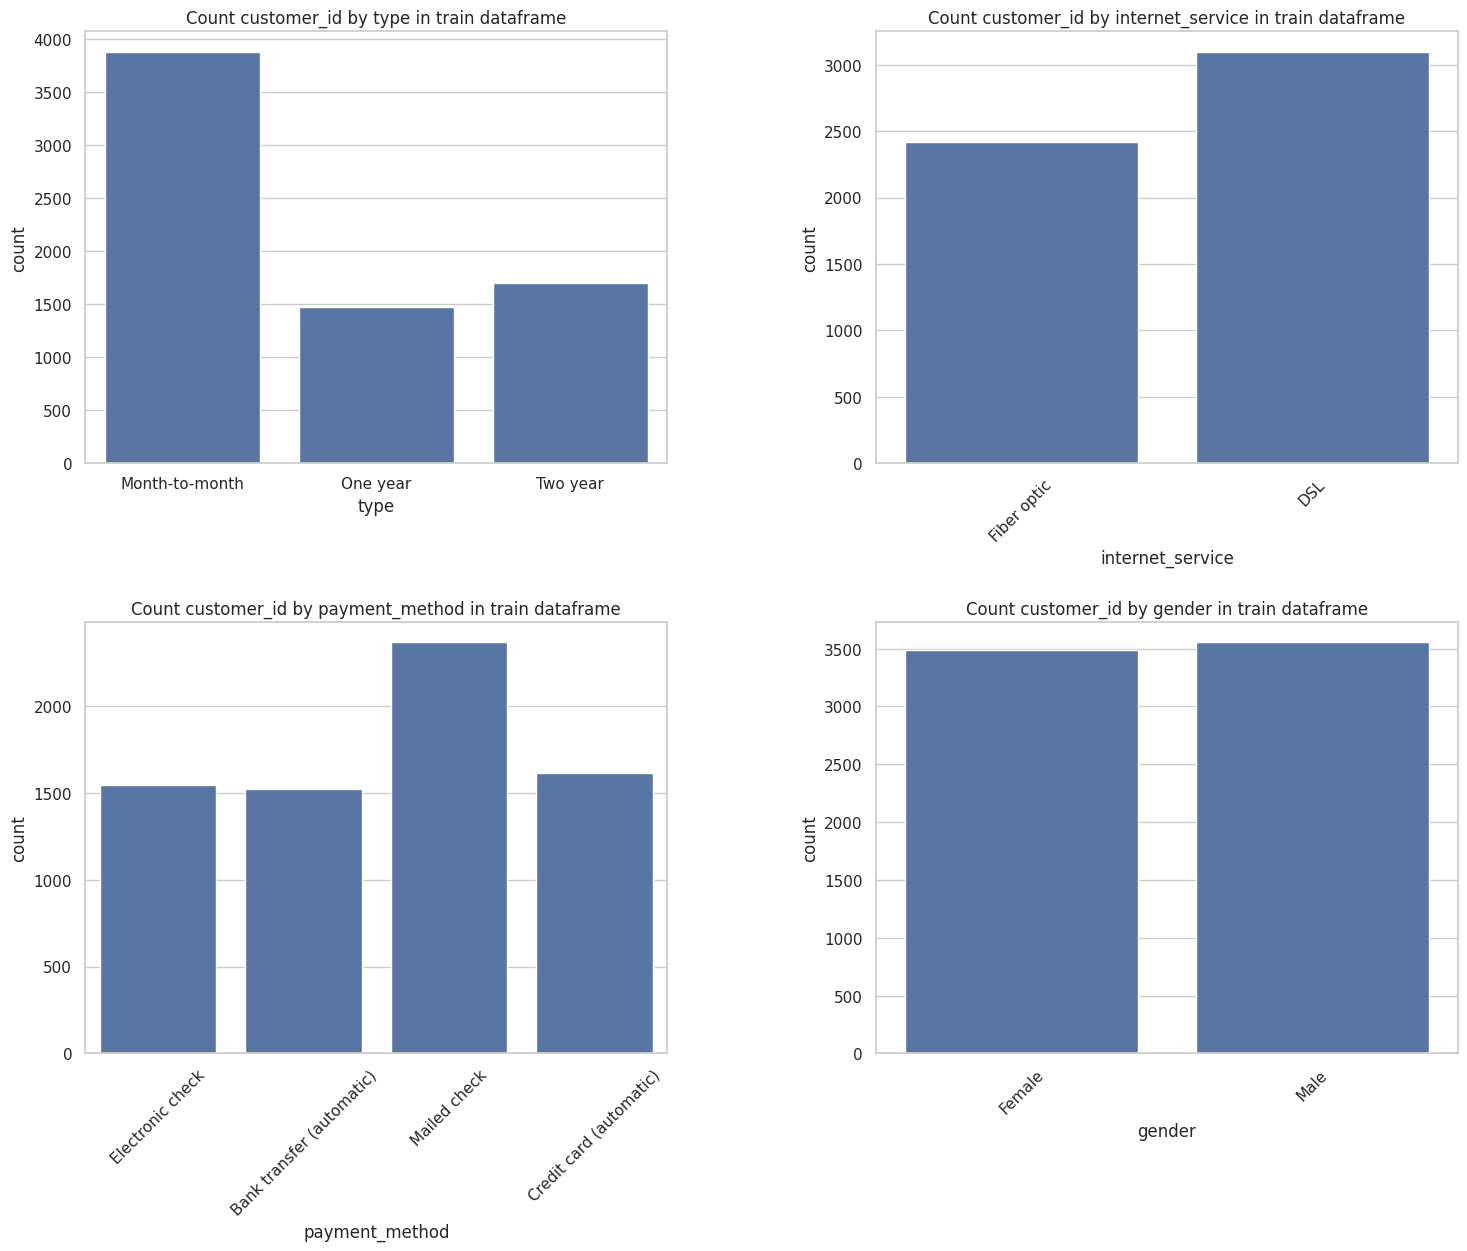

In [149]:
fig, axs = plt.subplots(2, 2)
fig.tight_layout(pad=1.6)
fig.set_size_inches(16.5, 12.5, forward=True)


x = "type"
y = "customer_id"
stat = ["count"]
agg_df = df.groupby(x)[y].agg(stat)
sns.barplot(data=agg_df, x=x, y= stat[0], ax=axs[0, 0])
axs[0, 0].set_title(f'Count {y} by {x} in train dataframe')

x = "payment_method"
y = "customer_id"
# ваш код тут #
agg_df = df.groupby(x)[y].agg(stat)
sns.barplot(data=agg_df, x=x, y= stat[0], ax=axs[1, 0])
axs[1, 0].set_title(f'Count {y} by {x} in train dataframe')
axs[1, 0].set_xticklabels(df[x].unique(), rotation = 45);

x = "internet_service"
y = "customer_id"
stat = ["count"]
agg_df = df.groupby(x)[y].agg(stat)
sns.barplot(data=agg_df, x=x, y=stat[0], ax=axs[0, 1])
# ваш код тут #
axs[0, 1].set_title(f'Count {y} by {x} in train dataframe')
axs[0, 1].set_xticklabels(df[x].unique(), rotation = 45);

x = "gender"
y = "customer_id"
stat = ["count"]
agg_df = df.groupby(x)[y].agg(stat)
sns.barplot(data=agg_df, x=x, y=stat[0], ax=axs[1, 1])
# ваш код тут #
axs[1, 1].set_title(f'Count {y} by {x} in train dataframe')
axs[1, 1].set_xticklabels(df[x].unique(), rotation = 45);

plt.savefig(os.path.join(ASSETS_DIR, 'cat_features_1'))

In [150]:
x = "customer_id"
binary_columns = [
    "online_security", 
    "online_backup", 
    "device_protection", 
    "tech_support",
    "streaming_tv",
    "streaming_movies",
    "senior_citizen",
    "partner",
    "dependents",
]
stat = ["count"]


print(df.groupby(binary_columns).agg(stat[0])[x].reset_index().sort_values(by=x, ascending=False).head(10))



    online_security online_backup device_protection tech_support streaming_tv   
0                No            No                No           No           No  \
106              No           Yes                No           No           No   
414             Yes           Yes               Yes          Yes          Yes   
4                No            No                No           No           No   
8                No            No                No           No           No   
15               No            No                No           No          Yes   
214             Yes            No                No           No           No   
22               No            No                No           No          Yes   
413             Yes           Yes               Yes          Yes          Yes   
3                No            No                No           No           No   

    streaming_movies  senior_citizen partner dependents  customer_id  
0                 No               0 

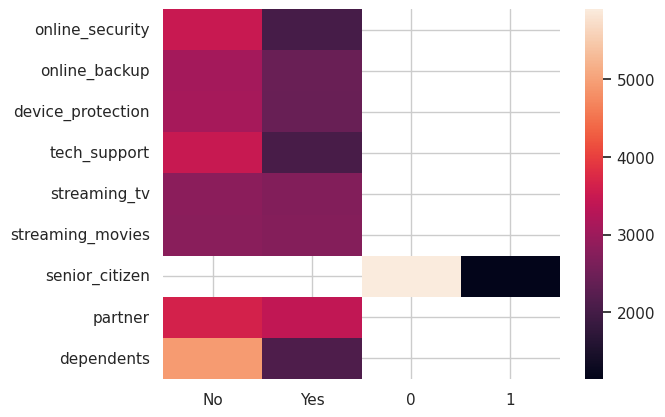

In [151]:
# построить тепловую карту бинарных признаков 
heat_df = df[binary_columns].apply(pd.Series.value_counts).T
sns.heatmap(heat_df)

plt.savefig(os.path.join(ASSETS_DIR, 'cat_features_2_binary_heatmap'))

/tmp/ipykernel_416159/2793587432.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[charges_columns].dropna(inplace=True)


,begin_date,monthly_mean,monthly_median,monthly_mode
0,2013-10-01,104.800000,104.150,92.45
1,2013-11-01,108.325000,108.325,108.05
2,2013-12-01,91.066667,93.700,65.30
3,2014-01-01,95.864286,104.050,54.20
4,2014-02-01,80.934153,89.475,24.75
...,...,...,...,...
72,2019-10-01,56.259705,58.500,19.95
73,2019-11-01,54.602110,55.800,20.20
74,2019-12-01,52.312955,54.050,19.90
75,2020-01-01,37.909013,25.400,19.75


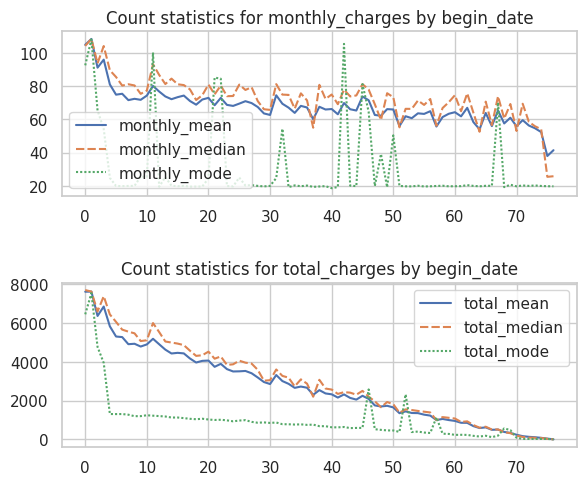

In [174]:
x = "begin_date"

# список колонок, для которых будут вычисляться статистики
charges_columns = [
    "monthly_charges",
    "total_charges",
]

# удаление пустых колонок для посчёта медианного значения
df[charges_columns].dropna(inplace=True)

# список статистик, которые будут вычисляться для каждой группы
stats = ["mean", "median", lambda x: x.mode().iloc[0]]  # среднее значение, медиана и мода

# группировка данных по дате начала и агрегация статистик для ежемесячных платежей (используйте reset_index для сброса индекса в таблице)
charges_monthly_agg = df.fillna(0).groupby(x)[charges_columns[0]].agg(stats).reset_index() # ваш код здесь #

# удаление верхнего уровня индекса колонок (после агрегации)
#charges_monthly_agg.columns = charges_monthly_agg.columns.droplevel()
# переименование колонок для удобства восприятия
charges_monthly_agg.columns = [x, "monthly_mean", "monthly_median", "monthly_mode"]

# аналогично для общих платежей
charges_total_agg = df.fillna(0).groupby(x)[charges_columns[1]].agg(stats).reset_index() # ваш код здесь #
#charges_total_agg.columns = charges_total_agg.columns.droplevel()
charges_total_agg.columns = [x, "total_mean", "total_median", "total_mode"]

# создание объекта для отображения графиков (2 графика вертикально)
fig, axs = plt.subplots(2,1) # ваш код здесь #
# настройка отступов между графиками
fig.tight_layout(pad=2.5)
# установка размера фигуры
fig.set_size_inches(6.5, 5.5, forward=True)

# построение линейных графиков для ежемесячных платежей
# ваш код здесь #
sns.lineplot(data=charges_monthly_agg, ax=axs[0])
# установка заголовка для верхнего графика
axs[0].set_title(f"Count statistics for {charges_columns[0]} by {x}")

# построение линейных графиков для общих платежей

sns.lineplot(data=charges_total_agg, ax=axs[1])
# установка заголовка для нижнего графика
axs[1].set_title(f"Count statistics for {charges_columns[1]} by {x}")
charges_monthly_agg

/tmp/ipykernel_416159/192785167.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[charges_columns].dropna(inplace=True)


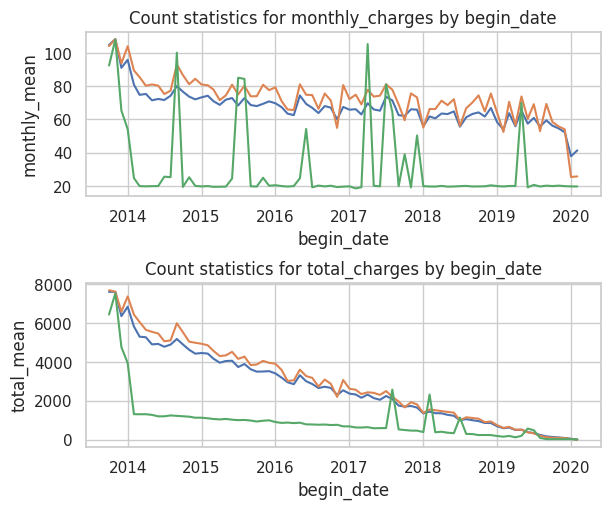

In [172]:
x = "begin_date"

# список колонок, для которых будут вычисляться статистики
charges_columns = [
    "monthly_charges",
    "total_charges",
]

# удаление пустых колонок для посчёта медианного значения
df[charges_columns].dropna(inplace=True)

# список статистик, которые будут вычисляться для каждой группы
stats = ["mean", "median", lambda x: x.mode().iloc[0]]  # среднее значение, медиана и мода

# группировка данных по дате начала и агрегация статистик для ежемесячных платежей (используйте reset_index для сброса индекса в таблице)
charges_monthly_agg = df[[x] + [charges_columns[0]]].fillna(0).groupby([x]).agg(stats).reset_index() # ваш код здесь #

#удаление верхнего уровня индекса колонок (после агрегации)
charges_monthly_agg.columns = charges_monthly_agg.columns.droplevel()
# переименование колонок для удобства восприятия
charges_monthly_agg.columns = [x, "monthly_mean", "monthly_median", "monthly_mode"]

# аналогично для общих платежей
charges_total_agg = df[[x] + [charges_columns[1]]].fillna(0).groupby([x]).agg(stats).reset_index()# ваш код здесь #
charges_total_agg.columns = charges_total_agg.columns.droplevel()
charges_total_agg.columns = [x, "total_mean", "total_median", "total_mode"]

# создание объекта для отображения графиков (2 графика вертикально)
fig, axs = plt.subplots(2,1) # ваш код здесь #
# настройка отступов между графиками
fig.tight_layout(pad=2.5)
# установка размера фигуры
fig.set_size_inches(6.5, 5.5, forward=True)

# построение линейных графиков для ежемесячных платежей
# ваш код здесь #
sns.lineplot(charges_monthly_agg, ax=axs[0], x=x, y='monthly_mean')
sns.lineplot(charges_monthly_agg, ax=axs[0], x=x, y='monthly_median')
sns.lineplot(charges_monthly_agg, ax=axs[0], x=x, y='monthly_mode')
# установка заголовка для верхнего графика
axs[0].set_title(f"Count statistics for {charges_columns[0]} by {x}")

# построение линейных графиков для общих платежей

sns.lineplot(charges_total_agg, ax=axs[1], x=x, y='total_mean')
sns.lineplot(charges_total_agg, ax=axs[1], x=x, y='total_median')
sns.lineplot(charges_total_agg, ax=axs[1], x=x, y='total_mode')
# установка заголовка для нижнего графика
axs[1].set_title(f"Count statistics for {charges_columns[1]} by {x}")

plt.savefig(os.path.join(ASSETS_DIR, 'charges_by_date'))

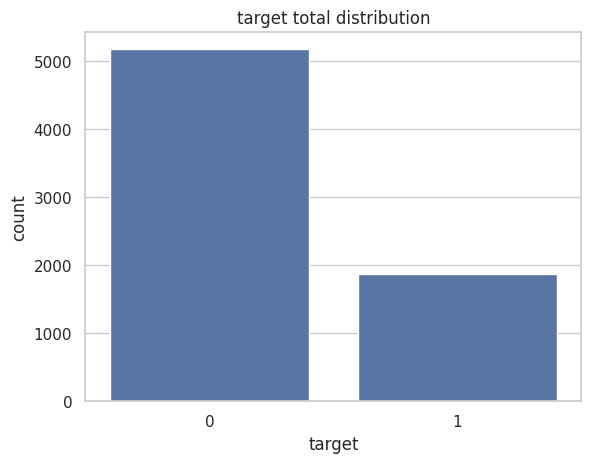

In [195]:
# директория для сохранения картинок
ASSETS_DIR = 'assets' # ваш код здесь #

# установка названия колонки для агрегации
x = "target"

# подсчёт количества каждого уникального значения в колонке и сброс индекса для последующей визуализации
target_agg = df[x].value_counts().reset_index() # ваш код здесь #

# создание столбчатой диаграммы для визуализации распределения целевой переменной
# ваш код здесь #
sns.barplot(data=target_agg, x=x, y='count')
# установка заголовка графика
plt.title(f"{x} total distribution")

# сохранение графика в файл
# ваш код здесь #b

plt.savefig(os.path.join(ASSETS_DIR, 'target_count'))

In [236]:
# установка переменных для анализа
x = "begin_date"
target = "target"

# определение статистики для агрегации
stat = ["count"]

# агрегация количества целей по датам начала с последующим сбросом индекса

target_agg_by_date = df[[x, target]].groupby([x]).agg(stat).reset_index()
# удаление мультиуровневости заголовков после агрегации и переименование для удобства
target_agg_by_date.columns = target_agg_by_date.columns.droplevel()
target_agg_by_date.columns = [x, "target_count"]
 
# подсчёт количества клиентов для каждого значения цели по датам
target_agg = df[[x, target, 'customer_id']].groupby([x, target]).count().reset_index()

# расчёт суммы и количества для конверсии по датам

conversion_agg = df[[x, target]].groupby([x])['target'].agg(['sum', 'count']).reset_index()
conversion_agg['conv'] = (conversion_agg['sum'] / conversion_agg['count']).round(2)


# аналогичный расчет конверсии, но с дополнительным разделением по полу
conversion_agg_gender = df[[x, target, 'gender']].groupby([x, 'gender'])[target].agg(['sum', 'count']).reset_index()
  # ваш код здесь #
conversion_agg_gender['conv'] = (conversion_agg_gender['sum'] / conversion_agg_gender['count']).round(2)


In [235]:
target_agg_by_date.columns.droplevel()
target_agg_by_date.columns = [x, "target_count"]
target_agg_by_date.columns

Index(['begin_date', 'target_count'], dtype='object')

In [244]:
conversion_agg_gender

,begin_date,gender,sum,count,conv
0,2013-10-01,Female,1,1,1.00
1,2013-10-01,Male,2,2,1.00
2,2013-11-01,Male,2,2,1.00
3,2013-12-01,Female,3,3,1.00
4,2014-01-01,Female,3,3,1.00
...,...,...,...,...,...
147,2019-12-01,Male,50,103,0.49
148,2020-01-01,Female,0,98,0.00
149,2020-01-01,Male,0,135,0.00
150,2020-02-01,Female,0,5,0.00


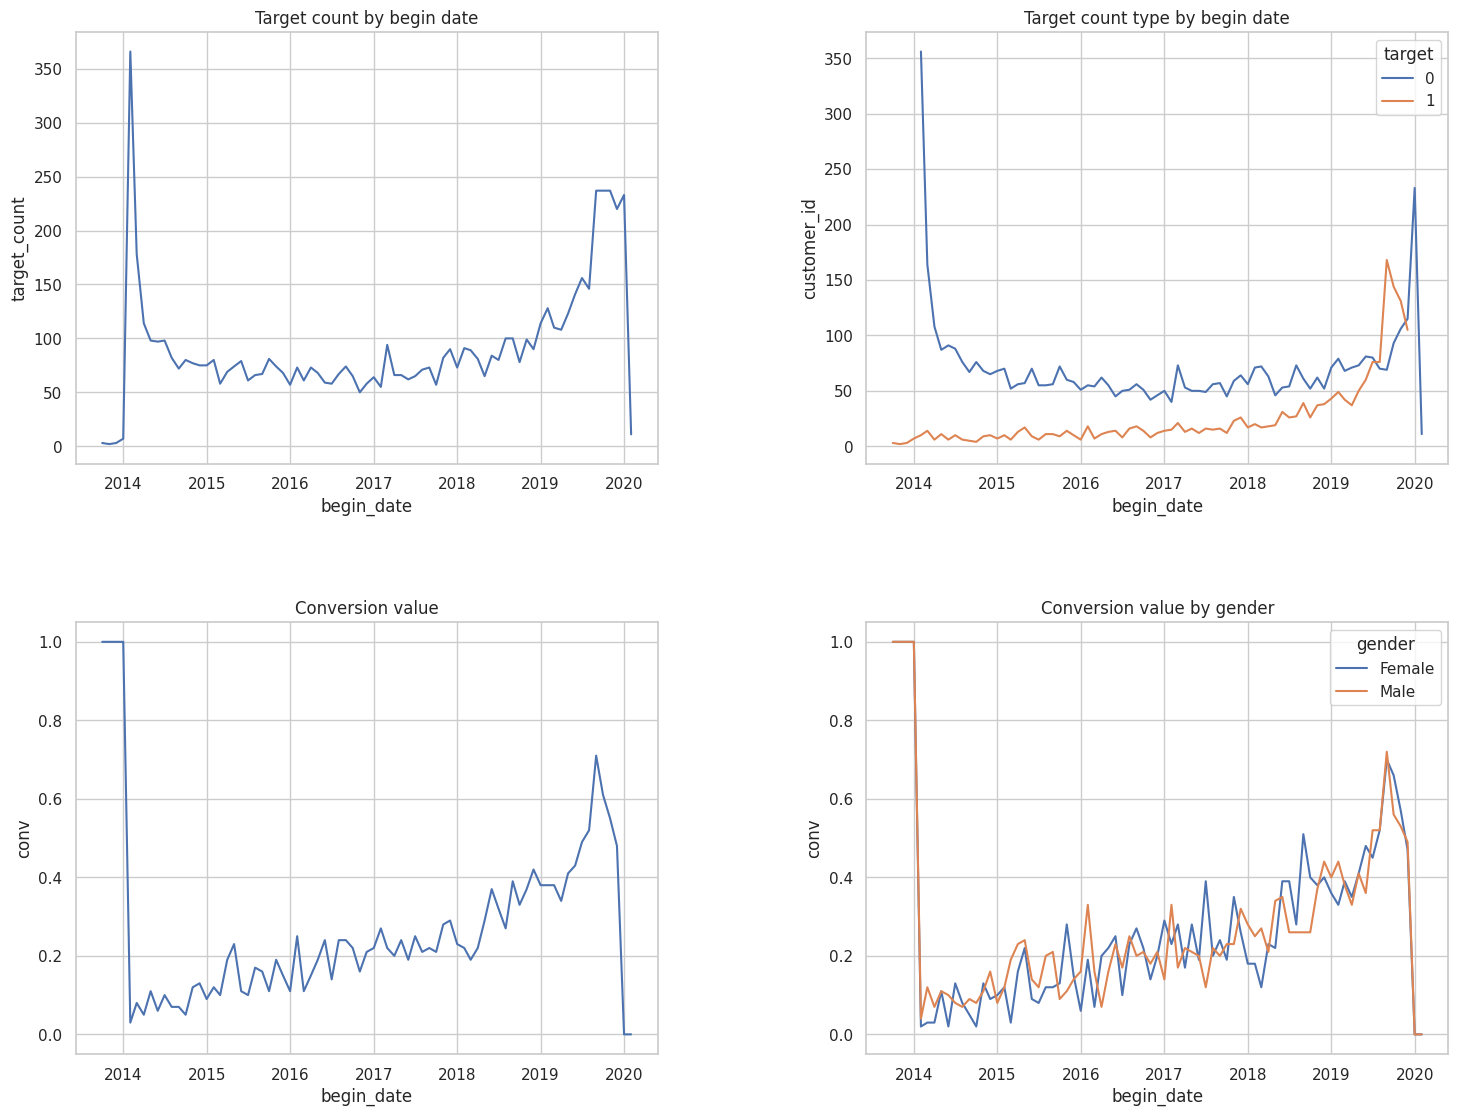

In [250]:

# инициализация фигуры для отображения нескольких графиков
fig, axs = plt.subplots(2, 2)
fig.tight_layout(pad=1.6)  # настройка отступов между подграфиками
fig.set_size_inches(16.5, 12.5, forward=True)  # установка размера фигуры

# визуализация общего количества целей по датам начала
# ваш код здесь #
sns.lineplot(data=target_agg_by_date, x=x, y="target_count", ax=axs[0, 0])
axs[0, 0].set_title("Target count by begin date")

# визуализация количества клиентов для каждого типа цели по датам
# ваш код здесь #
sns.lineplot(data=target_agg, x=x, y="customer_id", hue=target, ax=axs[0, 1])
axs[0, 1].set_title("Target count type by begin date")

# визуализация коэффициента конверсии по датам
# ваш код здесь #
sns.lineplot(data=conversion_agg, x=x, y="conv", ax=axs[1, 0])
axs[1, 0].set_title("Conversion value")

# визуализация коэффициента конверсии по датам с разделением по полу
# ваш код здесь #
sns.lineplot(data=conversion_agg_gender, x=x, y="conv", hue='gender', ax=axs[1, 1])
axs[1, 1].set_title("Conversion value by gender")

# сохранение визуализации в файл
# ваш код здесь #
plt.savefig(os.path.join(ASSETS_DIR, 'target_by_date'))

In [252]:
df.

,id,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines,target
0,4815,7270-BDIOA,2017-12-01,2019-10-01,Month-to-month,Yes,Electronic check,90.00,1993.80,Fiber optic,No,No,No,Yes,Yes,No,Female,0,No,No,Yes,1
1,3860,1732-FEKLD,2015-08-01,NaT,One year,Yes,Bank transfer (automatic),94.75,5121.75,Fiber optic,No,Yes,Yes,No,Yes,No,Female,0,No,No,Yes,0
2,1563,8259-NFJTV,2019-07-01,NaT,Month-to-month,No,Mailed check,34.65,246.60,DSL,Yes,No,No,Yes,No,No,Female,0,Yes,Yes,None,0
3,1564,3223-DWFIO,2019-10-01,NaT,Month-to-month,No,Electronic check,69.35,261.65,Fiber optic,No,No,No,No,No,No,Male,1,No,No,No,0
4,1565,2660-EMUBI,2018-12-01,2019-10-01,Month-to-month,Yes,Electronic check,95.35,898.35,Fiber optic,No,No,No,No,Yes,Yes,Male,1,No,No,Yes,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6934,6502-MJQAE,2019-11-01,2019-12-01,Month-to-month,Yes,Electronic check,69.60,69.60,Fiber optic,No,No,No,No,No,No,Male,0,No,No,No,1
7039,6935,6257-DTAYD,2014-03-01,NaT,Two year,Yes,Credit card (automatic),104.15,7365.30,Fiber optic,No,Yes,No,Yes,Yes,Yes,Male,0,Yes,No,Yes,0
7040,6936,4616-ULAOA,2014-09-01,NaT,Two year,Yes,Credit card (automatic),110.80,7245.90,Fiber optic,No,Yes,Yes,Yes,Yes,Yes,Female,0,Yes,Yes,Yes,0
7041,6937,7693-LCKZL,2019-05-01,2019-10-01,Month-to-month,Yes,Electronic check,80.15,385.00,Fiber optic,No,Yes,No,No,No,No,Male,0,Yes,Yes,Yes,1


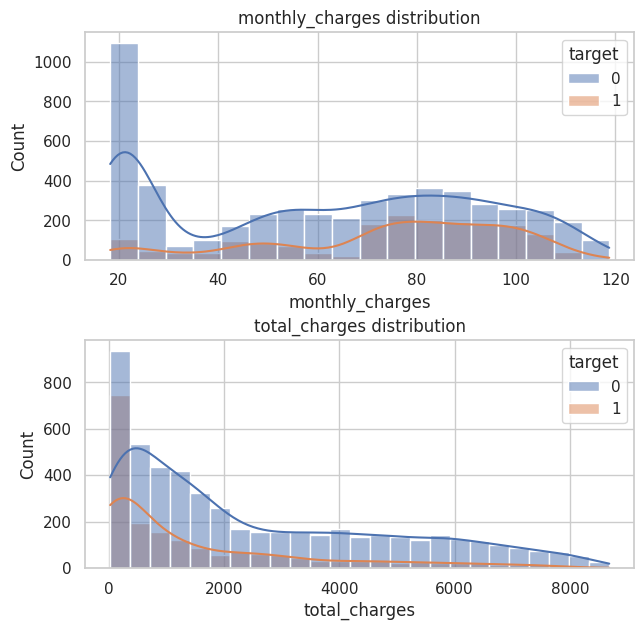

In [272]:
# определение списка столбцов с данными о платежах и целевой переменной
charges = ["monthly_charges", "total_charges"]
target = "target"

# инициализация фигуры для отображения гистограмм   
fig, axs = plt.subplots(2, 1)
fig.tight_layout(pad=1.5)  # настройка отступов между подграфиками
fig.set_size_inches(6.5, 6.5, forward=True)  # установка размера фигуры

# визуализация распределения ежемесячных платежей с разделением по целевой переменной
# ваш код здесь #
# датафрейм с данными
sns.histplot(data=df, x=charges[0], hue=target, kde=True, ax=axs[0])

# первый вид платежей для визуализации
# разделение данных по целевой переменной
# включение оценки плотности распределения (Kernel Density Estimate)
# указание, на каком подграфике отобразить гистограмму
axs[0].set_title(f"{charges[0]} distribution")  # установка заголовка для гистограммы

# визуализация распределения общих платежей с разделением по целевой переменной
# ваш код здесь #
# датафрейм с данными
# второй вид платежей для визуализации
# разделение данных по целевой переменной
# включение оценки плотности распределения
# указание, на каком подграфике отобразить вторую гистограмму
sns.histplot(data=df, x=charges[1], hue=target, kde=True, ax=axs[1])
axs[1].set_title(f"{charges[1]} distribution")  # Установка заголовка для второй гистограммы

# сохранение фигуры с гистограммами в файл
# ваш код здесь #
plt.savefig(os.path.join(ASSETS_DIR, 'chargest_by_target_dist'))

In [273]:
os.environ["MLFLOW_S3_ENDPOINT_URL"] = "https://storage.yandexcloud.net" #endpoint бакета от YandexCloud
os.environ["AWS_ACCESS_KEY_ID"] = os.getenv("AWS_ACCESS_KEY_ID") # получаем id ключа бакета, к которому подключён MLFlow, из .env
os.environ["AWS_SECRET_ACCESS_KEY"] = os.getenv("AWS_SECRET_ACCESS_KEY") # получаем ключ бакета, к которому подключён MLFlow, из .env


mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")
mlflow.set_registry_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")

experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id

    mlflow.log_artifacts(ASSETS_DIR)